<a href="https://colab.research.google.com/github/3778/COVID-19/blob/master/notebooks/%5Bissue_36%5D_Tunar_par%C3%A2metros_com_dados_hist%C3%B3rico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Referencias:
- https://kingaa.github.io/short-course/parest/parest.html

In [0]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

plt.style.use('ggplot')

In [2]:
# Check if we are in colab before cloning git repo.
IN_COLAB = 'google.colab' in sys.modules
CURRENT_DIR = !pwd

if IN_COLAB and not CURRENT_DIR[0].endswith('COVID-19/notebooks'):
    !git clone -l -s git://github.com/3778/COVID-19.git
    %cd COVID-19/notebooks
    !ls
else:
    print(f'Did not clone, already in directory {CURRENT_DIR[0]}')

Cloning into 'COVID-19'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 421 (delta 60), reused 143 (delta 36), pack-reused 237
Receiving objects: 100% (421/421), 594.50 KiB | 5.89 MiB/s, done.
Resolving deltas: 100% (189/189), done.
/content/COVID-19/notebooks


# Carregar e limpar dados de São Paulo

In [3]:
saopaulo = pd.read_csv('../data/csv/by_uf/SP.csv', parse_dates=['date'])
(saopaulo
 .tail()
 .rename(columns=lambda c: f'{c} ({saopaulo.dtypes[c]})'))

,date (datetime64[ns]),suspects (int64),refuses (int64),cases (int64),deaths (int64)
45,2020-03-14,752,545,65,0
46,2020-03-15,1125,551,136,0
47,2020-03-16,1177,623,152,0
48,2020-03-17,5047,709,164,1
49,2020-03-18,5334,596,240,4


In [4]:
saopaulo[saopaulo.duplicated('date', keep=False)]

,date,suspects,refuses,cases,deaths
7,2020-02-06,3,10,0,0
8,2020-02-06,3,10,0,0
27,2020-02-25,4,26,0,0
28,2020-02-25,4,26,0,0


Os dados possuem duplicatas de data, porém os registros são iguais nas 4 variáveis então podemos descartar e setar a data como índice.

In [0]:
saopaulo = (pd.read_csv('../data/csv/by_uf/SP.csv', parse_dates=['date'])
              .drop_duplicates('date')
              .set_index('date'))

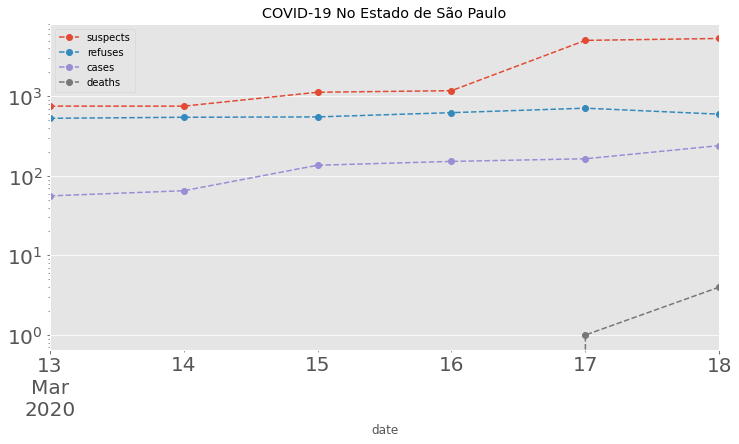

In [6]:
(saopaulo
 .query('cases >= 50')
 .plot(style='o--', figsize=(12,6), fontsize=20, 
       logy=True, title='COVID-19 No Estado de São Paulo'));

# Feature-based parameter estimation for SIR


## Estimating R0 in an invasion

In [0]:
# will only consider days after this number of cases
cases_th = 50

In [8]:
X, y = (saopaulo
        .query(f'cases >= {cases_th}')
        ['cases']
        .pipe(lambda s: (sm.add_constant(s.index.day.values),
                         np.log(s).values)))

X, y

(array([[ 1., 13.],
        [ 1., 14.],
        [ 1., 15.],
        [ 1., 16.],
        [ 1., 17.],
        [ 1., 18.]]),
 array([4.02535169, 4.17438727, 4.91265489, 5.02388052, 5.09986643,
        5.48063892]))

In [9]:
model = sm.OLS(y, X)
results = model.fit()
results.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     45.24
Date:                Thu, 19 Mar 2020   Prob (F-statistic):            0.00254
Time:                        15:40:49   Log-Likelihood:                 2.9713
No. Observations:                   6   AIC:                            -1.943
Df Residuals:                       4   BIC:                            -2.359
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2849      0.673      0.423      0.694      -1.584       2.154
x1             0.2904      0.043      6.726      0.003       0.171       0.410
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.351
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.594
Skew:                           0.702   Prob(JB):                        0.743
Kurtosis:                       2.365   Cond. No.                         143.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
gamma_inv = 12
R0_pred_int = results.conf_int()[1]/(1/gamma_inv) + 1
R0_pred_avg = results.params[1]/(1/gamma_inv) + 1

print(f'Considering days after the number of infected cases reached {cases_th},'
      f' R0 is estimated to be {R0_pred_avg:.03} with CI95% '
      f'({R0_pred_int[0]:.03}, {R0_pred_int[1]:.03}) for the state of '
       'São Paulo.\nThis assumes an early'
      f' stage outbreak SIR model and time to recovery (1/γ) of {gamma_inv} days.')

Considering days after the number of infected cases reached 50, R0 is estimated to be 4.48 with CI95% (3.05, 5.92) for the state of São Paulo.
This assumes an early stage outbreak SIR model and time to recovery (1/γ) of 12 days.
